In [1]:
# @author = Hadi Daneshmand (ETH Zurich)
# X is n times d data matrix where n is number of samples and d is the dimension 
# lambd is the regularizer 

%pylab
%matplotlib inline

from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
import numpy as np
def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
class Ridge_Risk: # this class presents the ridge regression objective function 
    def __init__(self, X, y,lambd,primal = True):
        self.X = X
        self.y = y
        self.lambd = lambd
        self.optimal = -1 
        self.primal = primal
        self.row_norms_sq = np.square(np.linalg.norm(X, axis=1))
    def __str__(self):
        return ("square loss with lambd = %f" % self.lambd)
    def get_w(self,alpha): 
        n, d = self.X.shape
        w = np.zeros(d)
        for i in range(n): 
            w = w + alpha[i]*self.X[i,:]/(self.lambd*n)
        return w
    def get_dual(self,alpha): 
        da = 0
        n, d = self.X.shape
        for i in range(n):         
            da = da + alpha[i]*self.y[i] - 0.25*alpha[i]*alpha[i]
        da = da/float(n)
        da = da - 0.5*self.lambd*np.square(np.linalg.norm(self.get_w(alpha)))
        return da
    def get_primal(self,w): 
        n, d = self.X.shape
        pw = 0
        for i in range(n): 
            dif = np.dot(self.X[i,:],w) - self.y[i]
            pw = pw + dif*dif
        pw = pw/float(n)
        pw = pw + 0.5*self.lambd*np.square(np.linalg.norm(w))
        return pw
    def get_sdca_update(self,w,ii,alpha_i_old): 
        xi = self.X[ii,:] 
        yi = self.y[ii] 
        sqi = self.row_norms_sq[ii]
        n, d = self.X.shape
        return (yi- np.dot(xi,w)-0.5*alpha_i_old)/(0.5+sqi/(self.lambd*n)) 
    def get_w_update(self,ii,delta_alpha_i): 
        n, d = self.X.shape
        return delta_alpha_i*self.X[ii,:]/(self.lambd*n)
    def get_sub_risk(self,indeces,lambd): 
        return Ridge_Risk(self.X[indeces,:],self.y[indeces],lambd)
    def get_suboptimality(self,w,alpha): 
        if self.optimal == -1:
           n, d = self.X.shape
           mu = np.dot(np.transpose(self.X),self.y)/float(n)
           cov = np.dot(np.transpose(self.X)/math.sqrt(n),X/math.sqrt(n))
           self.opt_w = np.dot(np.linalg.inv(np.add(2*cov,np.multiply(np.eye(d),self.lambd))),2*mu)
           self.optimal = self.get_primal(self.opt_w)
        if(self.primal): 
            return self.get_primal(w) - self.optimal
        else: 
            return self.optimal - self.get_dual(alpha)
def sdca_opt(risk, num_effective_passes, lambd0 = -1, alpha0 = None, verbose = False, stat_per_iter = False): 
  n, d = risk.X.shape
  rperm = np.random.permutation(n);
  if alpha0 is None: 
    alpha = np.zeros(n)
  else : 
    alpha = np.copy(alpha0)
  w = risk.get_w(alpha)
  obj_value = risk.get_suboptimality(w,alpha) 
  sample_size = n
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
  itrs = [0.0]
  optimality = [obj_value]
  completed_effective_passes = 0.0
  while completed_effective_passes < num_effective_passes:
    coords = rperm[np.random.permutation(sample_size)] 
    t = 0 
    for ii in coords:
        t = t + 1
        alpha_i_old = alpha[ii]
        # coordinate update step 
        delta_alpha_i = risk.get_sdca_update(w,ii,alpha_i_old)
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + risk.get_w_update(ii,delta_alpha_i)
        if stat_per_iter == True and (t % 100 == 0): 
            obj_value = risk.get_suboptimality(w,alpha)
            itrs.append(completed_effective_passes + (t/float(n)))
            optimality.append(obj_value)
    past_ef_pass = completed_effective_passes
    completed_effective_passes += len(coords) / float(n)
    obj_value = risk.get_suboptimality(w,alpha)
    itrs.append(completed_effective_passes)
    optimality.append(obj_value)
    if verbose:
      print("Obj[{}]= {},delta_alpha = {},sqi={}".format(completed_effective_passes, obj_value,(np.dot(xi,w)),sqi))
  return (alpha, itrs,optimality,w)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10


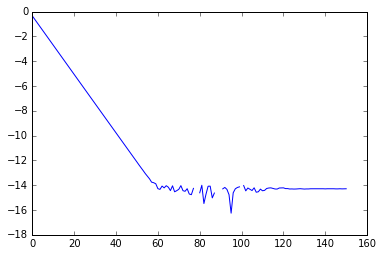

In [3]:
n = 32561; 
d = 123; 
import math
lambd1 = 10.0/float(n)
epochs = 150
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
rperm = np.random.permutation(n)
X = X[rperm,:]
y = y[rperm]
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
risk_ridge = Ridge_Risk(X,y,lambd1,False)
#_,steps_sgd_sdca,dual_sgd_sdca,_ = sgd_for_sdca(risk = risk_ridge,num_effective_passes = epochs,obj = objective_dual)
(alpha, itrs,optimality,w) = sdca_opt(risk = risk_ridge, num_effective_passes = epochs)
plt.plot(itrs,np.log10(optimality))
#plt.plot(steps_sgd_sdca,np.log10(dual_sgd_sdca),label = 'sgd for sdca')
#plt.savefig('plot/a9a_adaptive_sdca_dual_convergence.eps',format = 'eps')
#clustered_distributed_test(X,y,lambd,k)
#dual_transfer_test(X,y,lambd,k)
#partial_distributed_test(X,y,lambd,k)
#alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_ridge_dual.eps",primal_accuracy =False)

In [40]:
risk_ridge.get_dual(alpha)

0.22426141712695319

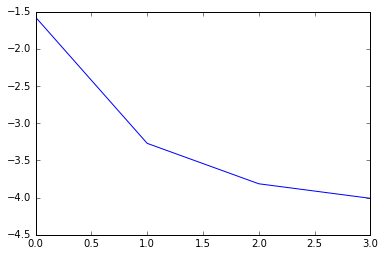

In [11]:
lambd_small = lambd1/100
risk_small = Ridge_Risk(X,y,lambd_small,False)
new_alpha, new_itrs, new_opts, new_w = sdca_opt(risk = risk_small, num_effective_passes =3, alpha0= alpha, stat_per_iter=False)
nitr = np.multiply(new_itrs,n)
plt.plot((new_itrs),np.log10(new_opts))


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


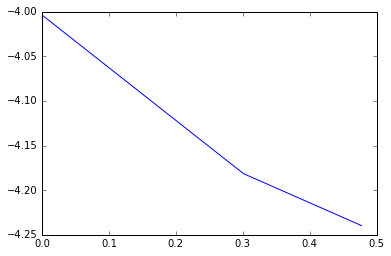

In [6]:
lambd_small = lambd1/10.0
risk_small = Ridge_Risk(X,y,lambd_small,False)
new_alpha, new_itrs, new_opts, new_w = sdca_opt(risk = risk_small, num_effective_passes =3, alpha0= alpha, stat_per_iter=False)
nitr = np.multiply(new_itrs,n)
plt.plot(np.log10(new_itrs),np.log10(new_opts))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


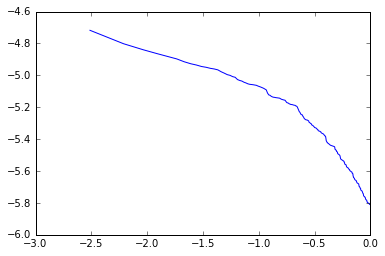

In [ ]:
n = 32561; 
d = 123; 
from sklearn.cluster import KMeans
import math
lambd = 1.0/math.sqrt(n)
epochs = 4
k = 2
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
rperm = np.random.permutation(n)
X = X[rperm,:]
y = y[rperm]
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
clf = Ridge(alpha=lambd*n,fit_intercept=False)
clf.fit(X, y)
risk_ridge = Ridge_Risk_C(X,y,lambd)
primal_opt =  risk_ridge.get_primal(clf.coef_)
def objective_dual(w,alpha,risk): 
    return primal_opt - risk.get_dual(alpha)
def objective_primal(w,alpha,risk): 
    #print( primal_func(w,alpha,X,y,lambd) - primal_opt)
    return   risk.get_primal(w) - primal_opt
#_,steps_sgd_sdca,dual_sgd_sdca,_ = sgd_for_sdca(risk = risk_ridge,num_effective_passes = epochs,obj = objective_dual)
steps_adap, dual_adapt = distributed_simulation(risk_ridge,k,epochs,obj = objective_dual)
_,steps_sdca,dual_sdca,_ = sdca_opt(risk = risk_ridge, num_effective_passes = epochs,obj = objective_dual)

plt.plot(steps_adap,np.log10(dual_adapt),label = 'adaptive sdca')
plt.plot(steps_sdca,np.log10(dual_sdca), label = 'sdca')
#plt.plot(steps_sgd_sdca,np.log10(dual_sgd_sdca),label = 'sgd for sdca')
plt.legend()
plt.savefig('plot/a9a_adaptive_sdca_dual_convergence.eps',format = 'eps')
#clustered_distributed_test(X,y,lambd,k)
#dual_transfer_test(X,y,lambd,k)
#partial_distributed_test(X,y,lambd,k)
#alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_ridge_dual.eps",primal_accuracy =False)

In [ ]:
n = 32561; 
d = 123; 
from sklearn.cluster import KMeans
lambd = 1.0/math.sqrt(n)
epochs = 4
k = 2
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
rperm = np.random.permutation(n)
X = X[rperm,:]
y = y[rperm]
clf = Ridge(alpha=lambd*n,fit_intercept=False)
clf.fit(X, y)
risk_ridge = Ridge_Risk_C(X,y,lambd)
primal_opt =  risk_ridge.get_primal(clf.coef_)
def objective_dual(w,alpha,risk): 
    return primal_opt - risk.get_dual(alpha)
def objective_primal(w,alpha,risk): 
    #print( primal_func(w,alpha,X,y,lambd) - primal_opt)
    return   risk.get_primal(w) - primal_opt
#_,steps_sgd_sdca,dual_sgd_sdca,_ = sgd_for_sdca(risk = risk_ridge,num_effective_passes = epochs,obj = objective_dual)
steps_adap, dual_adapt = distributed_simulation(risk_ridge,k,epochs,obj = objective_primal)
_,steps_sdca,dual_sdca,_ = sdca_opt(risk = risk_ridge, num_effective_passes = epochs,obj = objective_primal)

plt.plot(steps_adap,np.log10(dual_adapt),label = 'adaptive sdca')
plt.plot(steps_sdca,np.log10(dual_sdca), label = 'sdca')
#plt.plot(steps_sgd_sdca,np.log10(dual_sgd_sdca),label = 'sgd for sdca')
plt.legend()
plt.savefig('plot/a9a_adaptive_sdca_primal_convergence.eps',format = 'eps')
#clustered_distributed_test(X,y,lambd,k)
#dual_transfer_test(X,y,lambd,k)
#partial_distributed_test(X,y,lambd,k)
#alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_ridge_dual.eps",primal_accuracy =False)